# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score, explained_variance_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

import torch

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    from tools import lstm
    import params
    defs = params.monkey_defs
    monkey_defs = defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(params)
    reload(defs)

finally:
    os.chdir(nbPath)

if "__file__" not in dir():

    %run "_dataset-selection.ipynb"

# Read data

In [2]:

full_list = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(defs.prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")


## Plotting decoding performance using VAF

In [3]:
def custom_r2_vaf(y_true, y_pred):
    mask = np.logical_and(np.logical_not(np.isnan(y_true)),
                          np.logical_not(np.isnan(y_pred)))
    return explained_variance_score(y_true[mask], y_pred[mask])


def custom_r2_corr(y_true, y_pred):
    "$R^2$ value as squared correlation coefficient, as per Gallego, NN 2020"

    mask = np.logical_and(np.logical_not(np.isnan(y_true)),
                          np.logical_not(np.isnan(y_pred)))
    c = np.corrcoef(y_true[mask].T, y_pred[mask].T) ** 2
    return np.diag(c[-int(c.shape[0]/2):,:int(c.shape[1]/2)])


In [10]:
def plot_monkey_decoding(ax, allDFs, custom_r2_func):
    defs = monkey_defs

    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                    area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        *_,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_time,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,2))
        
        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
            lstm_model.fit(x_train=x_train, y_train=y_train)
            pred, label = lstm_model.predict(x_test, y_test)
            fold_score.append(custom_r2_func(pred, label))
        fold_score = np.median(fold_score)
        within_score[df1.session[0]] = fold_score

        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue

            AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                        defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            *_,n_time,n_comp = AllData1.shape

            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel2 = AllVel2.reshape((-1,n_time,2))
            AllVel1 = AllVel1.reshape((-1,n_time,2))

            # train the aligned
            # U, V, _ = dt.procrustes_wrapper(X1, X2, fullReturn=True)
            *_,U, V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            pred, label = lstm_model.predict(V, AllVel2)
            aligned_score[df1.session[0]][df2.session[0]]=custom_r2_func(pred, label).mean()
            #================================
            # Unaligned
            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=X1, y_train=AllVel1)
            pred, label = lstm_model.predict(X2, AllVel2)
            unaligned_score[df1.session[0]][df2.session[0]]=custom_r2_func(pred, label).mean()

    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            ax.plot([1,2], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)

    
    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    # ax.set_ylim([-1,1])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_bounds([0,2])
    # ax.spines['left'].set_bounds([0,1])

    return unaligned_score, aligned_score, within_score

Running for a bad pair of sessions

100%|██████████| 2/2 [09:08<00:00, 274.17s/it]

{'Chewie:09-14-2016': {'Mihili:09-29-2014': 0.7777828574180603}, 'Mihili:09-29-2014': {}} {'Chewie:09-14-2016': {'Mihili:09-29-2014': 0.8624151349067688}, 'Mihili:09-29-2014': {}} {'Chewie:09-14-2016': 0.9981959164142609, 'Mihili:09-29-2014': 0.9999573528766632}


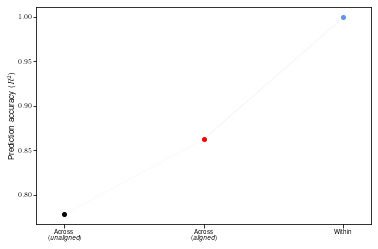

In [5]:
DFS=[]
for df in allDFs:
    if df.session[0] in ['Mihili:09-29-2014','Chewie:09-14-2016']:
        DFS.append(df)

fig, ax = plt.subplots(1,1)
pop_unaligned, pop_aligned, pop_within = plot_monkey_decoding(ax, DFS, custom_r2_vaf)
print(pop_unaligned, pop_aligned, pop_within)
np.savez('vaf-values-worst-session.npz', pop_unaligned=pop_unaligned,
            pop_aligned=pop_aligned,
            pop_within=pop_within)


In [5]:
data = np.load('vaf-values-worst-session.npz', mmap_mode=None, allow_pickle=True)
pop_unaligned = data['pop_unaligned']
pop_aligned = data['pop_aligned']
pop_within = data['pop_within']

In [7]:
pop_unaligned.flatten()[0]

{'Chewie:09-14-2016': {'Mihili:09-29-2014': 0.7777828574180603},
 'Mihili:09-29-2014': {}}

Running for all sessions

 48%|████▊     | 10/21 [1:32:33<2:14:58, 736.25s/it]/home/msafaie/REPOS/multi-animal-alignment/monkey/defs.py:130: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/home/msafaie/REPOS/multi-animal-alignment/monkey/defs.py:130: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/home/msafaie/REPOS/multi-animal-alignment/monkey/defs.py:130: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/home/msafaie/REPOS/multi-animal-alignment/monkey/defs.py:130: UserWarning: Dropping the trials with the following IDs because of invalid 

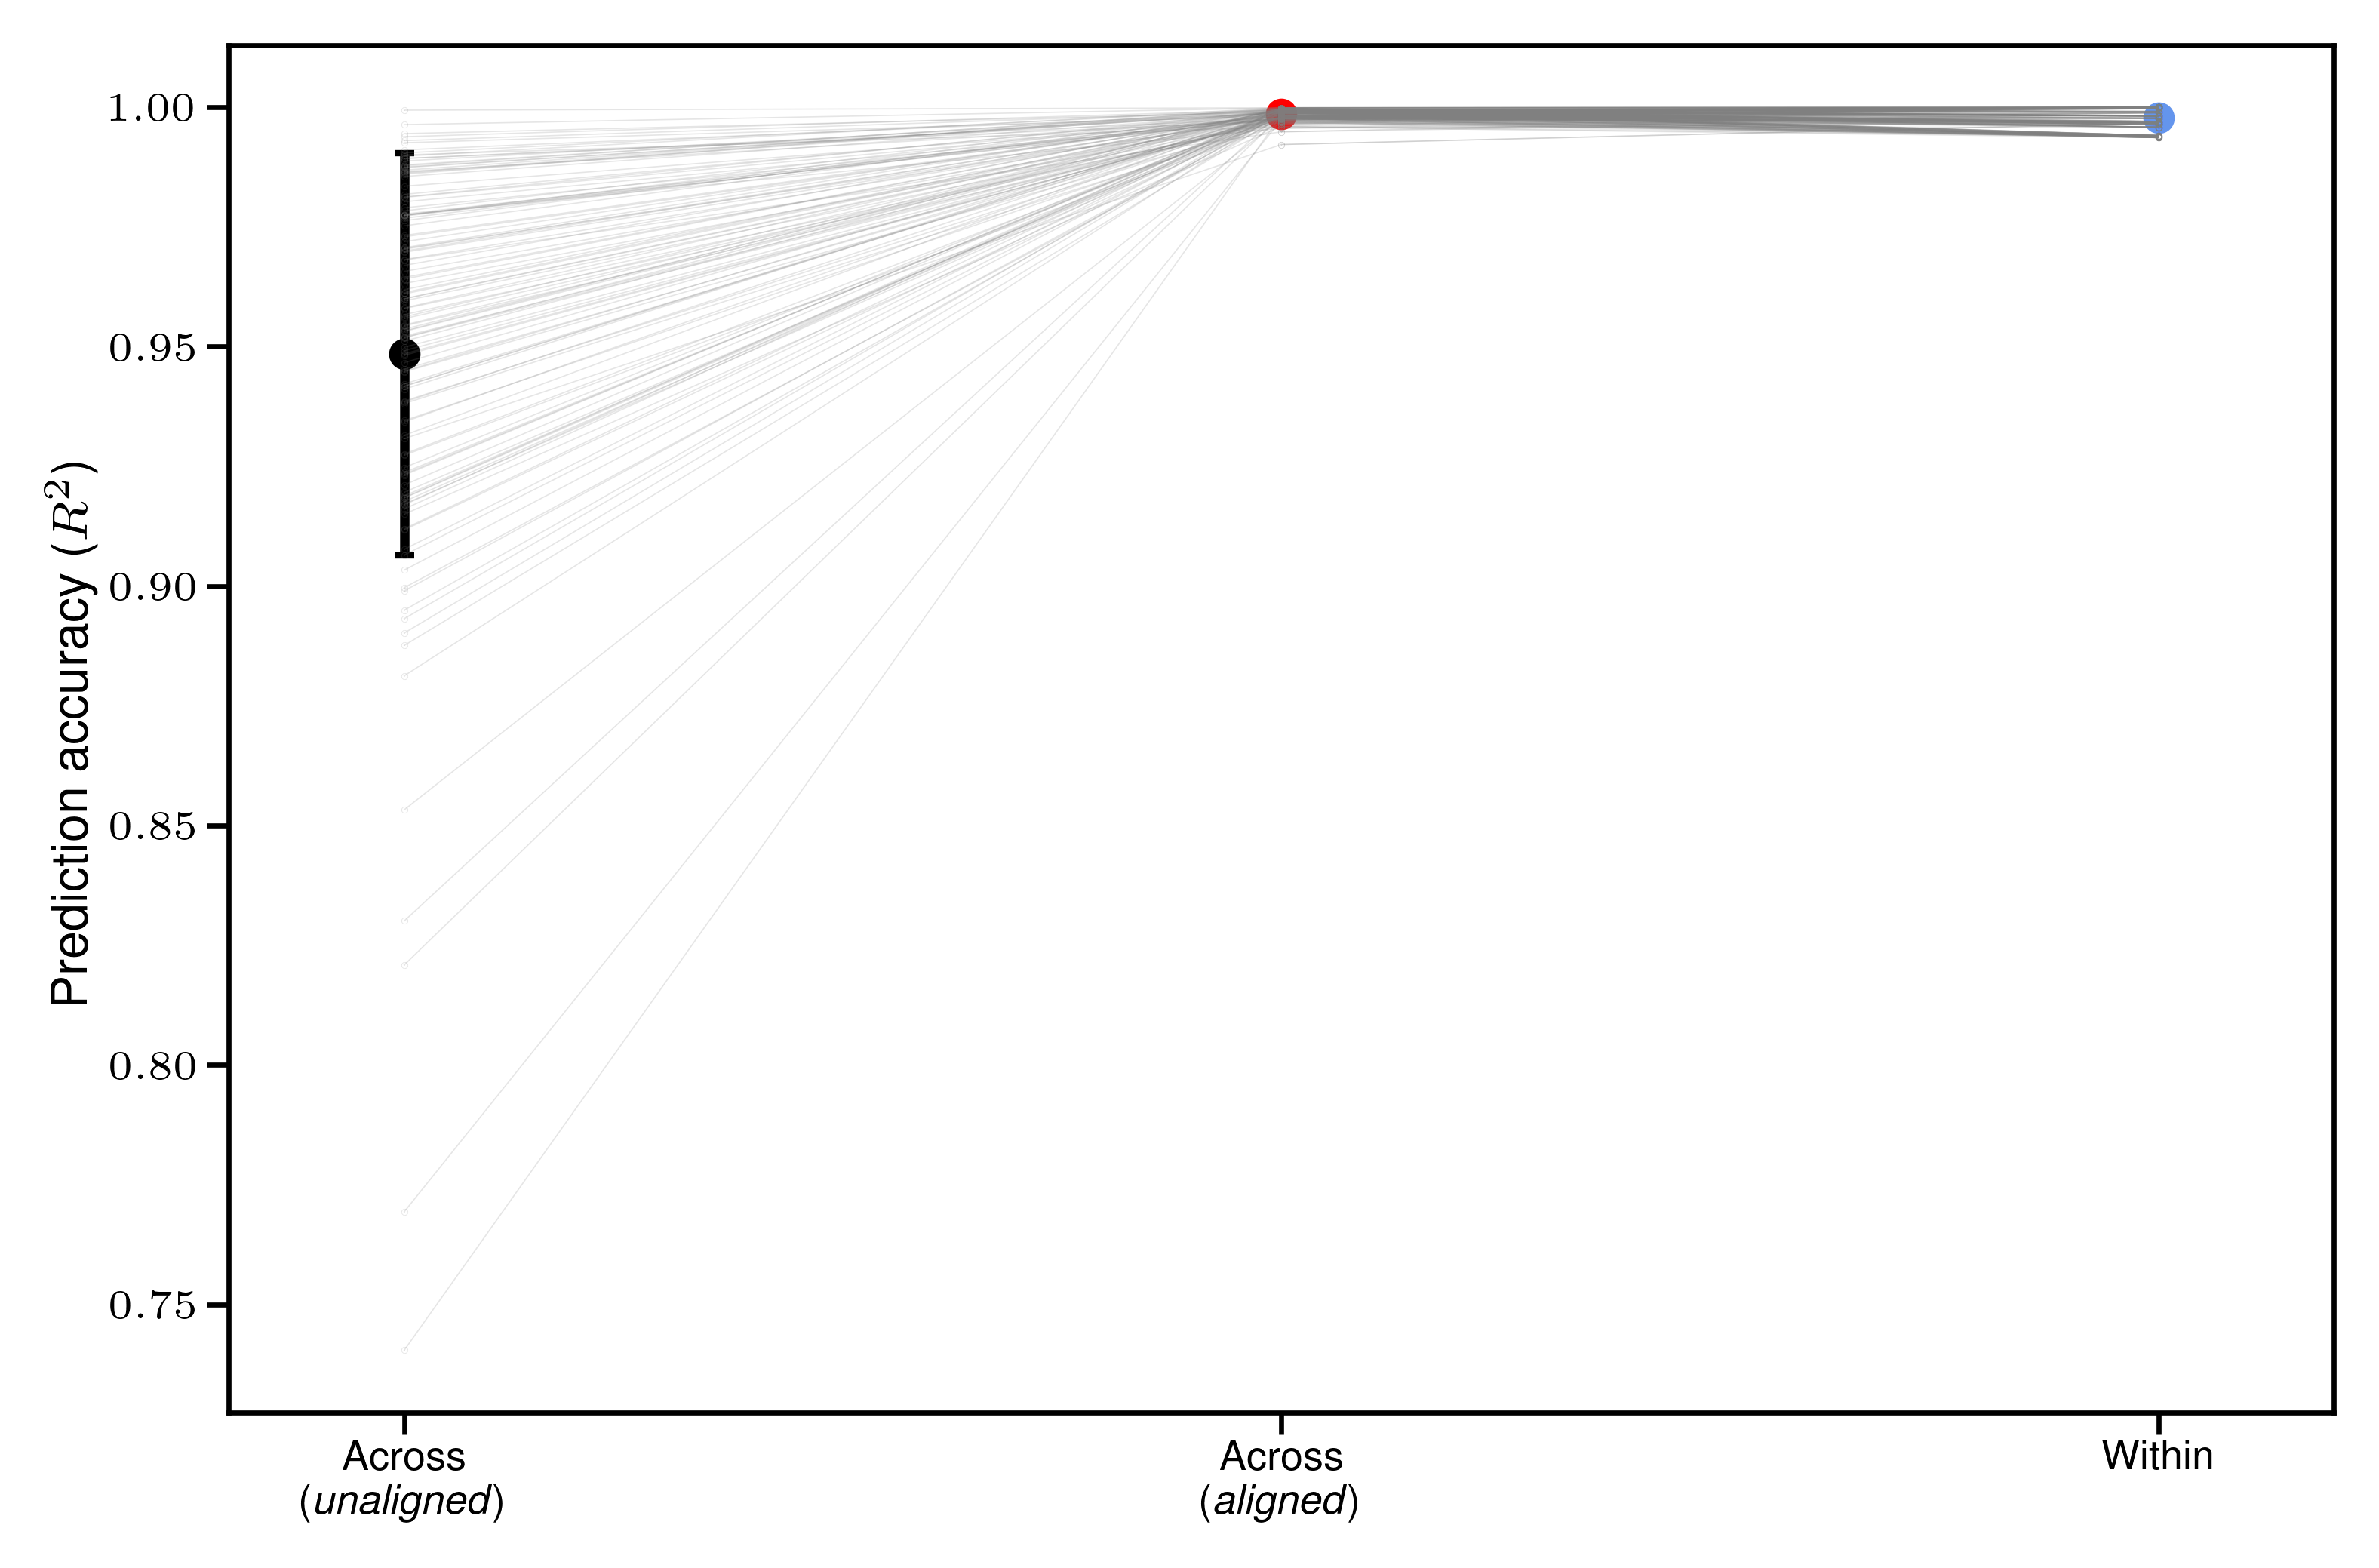

In [11]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()

    fig, ax = plt.subplots(1,1)  
    pop_unaligned, pop_aligned, pop_within = plot_monkey_decoding(ax, allDFs, custom_r2_corr)

    fig.savefig(params.figPath / 'decoding-vaf.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    np.savez('vaf-values.npz', pop_unaligned=pop_unaligned,
                pop_aligned=pop_aligned,
                pop_within=pop_within)


In [6]:
data = np.load('vaf-values.npz', mmap_mode=None,allow_pickle=True)
pop_unaligned = data['pop_unaligned']
pop_aligned = data['pop_aligned']
pop_within = data['pop_within']

In [ ]:
pop_aligned.flatten()[0]